The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1


# Redes Neurais Convolucionais (LeNet)
:label:`sec_lenet`


Agora temos todos os ingredientes necessários para montar
uma CNN totalmente funcional.
Em nosso encontro anterior com dados de imagem,
nós aplicamos
um modelo de regressão *softmax* (:numref: `sec_softmax_scratch`)
e
um modelo MLP (:numref:`sec_mlp_scratch`)
a fotos de roupas no conjunto de dados Fashion-MNIST.
Para tornar esses dados passíveis de regressão *softmax* e MLPs,
primeiro nivelamos cada imagem de uma matriz $28\times28$
em um vetor de comprimento fixo $784$-dimensional,
e depois os processamos com camadas totalmente conectadas.
Agora que temos um controle sobre as camadas convolucionais,
podemos reter a estrutura espacial em nossas imagens.
Como um benefício adicional de substituir camadas totalmente conectadas por camadas convolucionais,
desfrutaremos de modelos mais parcimoniosos que requerem muito menos parâmetros.

Nesta seção, apresentaremos *LeNet*,
entre as primeiras CNNs publicadas
para chamar a atenção para seu desempenho em tarefas de visão computacional.
O modelo foi apresentado por (e nomeado em homenagem a) Yann LeCun,
em seguida, um pesquisador da AT&T Bell Labs,
para fins de reconhecimento de dígitos manuscritos em imagens :cite:`LeCun.Bottou.Bengio.ea.1998`.
Este trabalho representou o culminar
de uma década de pesquisa desenvolvendo a tecnologia.
Em 1989, LeCun publicou o primeiro estudo com sucesso
treinar CNNs via retropropagação.

Na época, LeNet alcançou resultados excelentes
combinando o desempenho das máquinas de vetores de suporte,
em seguida, uma abordagem dominante na aprendizagem supervisionada.
LeNet foi eventualmente adaptado para reconhecer dígitos
para processar depósitos em caixas eletrônicos.
Até hoje, alguns caixas eletrônicos ainda executam o código
que Yann e seu colega Leon Bottou escreveram na década de 1990!


## LeNet

Em um alto nível, LeNet (LeNet-5) consiste em duas partes:
(i) um codificador convolucional que consiste em duas camadas convolucionais; e
(ii) um bloco denso que consiste em três camadas totalmente conectadas;
A arquitetura é resumida em :numref:`img_lenet`.

![Fluxo de dados em LeNet. A entrada é um dígito escrito à mão, a saída uma probabilidade de mais de 10 resultados possíveis.](http://d2l.ai/_images/lenet.svg)
:label:`img_lenet`


As unidades básicas em cada bloco convolucional
são uma camada convolucional, uma função de ativação *sigmoid*
e uma subsequente operação média de *pooling*.
Observe que, embora ReLUs e *max-pooling* funcionem melhor,
essas descobertas ainda não haviam sido feitas na década de 1990.
Cada camada convolucional usa um *kernel* $5\times 5$
e uma função de ativação *sigmoid*.
Essas camadas mapeiam entradas organizadas espacialmente
a uma série de mapas de recursos bidimensionais, normalmente
aumentando o número de canais.
A primeira camada convolucional tem 6 canais de saída,
enquanto o segundo tem 16.
Cada operação de *pooling* $2\times2$ (passo 2)
reduz a dimensionalidade por um fator de $4$ por meio da redução da resolução espacial.
O bloco convolucional emite uma saída com forma dada por
(tamanho do lote, número de canal, altura, largura).

Para passar a saída do bloco convolucional
para o bloco denso,
devemos nivelar cada exemplo no *minibatch*.
Em outras palavras, pegamos essa entrada quadridimensional e a transformamos
na entrada bidimensional esperada por camadas totalmente conectadas:
como um lembrete, a representação bidimensional que desejamos
usa a primeira dimensão para indexar exemplos no *minibatch*
e o segundo para dar a representação vetorial plana de cada exemplo.
O bloco denso do LeNet tem três camadas totalmente conectadas,
com 120, 84 e 10 saídas, respectivamente.
Porque ainda estamos realizando a classificação,
a camada de saída de 10 dimensões corresponde
ao número de classes de saída possíveis.

Chegar ao ponto em que você realmente entende
o que está acontecendo dentro do LeNet pode dar um pouco de trabalho, mas
espero que o seguinte *snippet* de código o convença
que a implementação de tais modelos com estruturas modernas de *deep learning*
é extremamente simples.
Precisamos apenas instanciar um bloco `Sequential`
e encadear as camadas apropriadas.


In [1]:
import torch
from torch import nn
from d2l import torch as d2l


class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 28, 28)

net = torch.nn.Sequential(
    Reshape(),
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

Tomamos uma pequena liberdade com o modelo original,
removendo a ativação gaussiana na camada final.
Fora isso, esta rede corresponde
a arquitetura LeNet-5 original.

Ao passar por um canal único (preto e branco)
$28 \times 28$ imagem através da rede
e imprimir a forma de saída em cada camada,
podemos inspecionar o modelo para ter certeza
que suas operações se alinham com
o que esperamos de :numref:`img_lenet_vert`.

![Compressed notation for LeNet-5.](../img/lenet-vert.svg)
:label:`img_lenet_vert`


In [2]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


Observe que a altura e largura da representação
em cada camada ao longo do bloco convolucional
é reduzido (em comparação com a camada anterior).
A primeira camada convolucional usa 2 pixels de preenchimento
para compensar a redução de altura e largura
que de outra forma resultaria do uso de um *kernel* $5 \times 5$.
Em contraste, a segunda camada convolucional dispensa o preenchimento,
e, portanto, a altura e a largura são reduzidas em 4 pixels.
Conforme subimos na pilha de camadas,
o número de canais aumenta camada sobre camada
de 1 na entrada a 6 após a primeira camada convolucional
e 16 após a segunda camada convolucional.
No entanto, cada camada de *pooling* divide a altura e a largura pela metade.
Finalmente, cada camada totalmente conectada reduz a dimensionalidade,
finalmente emitindo uma saída cuja dimensão
corresponde ao número de classes.



## Trainamento

Agora que implementamos o modelo,
vamos fazer um experimento para ver como o LeNet se sai no Fashion-MNIST.


In [3]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

Embora as CNNs tenham menos parâmetros,
eles ainda podem ser mais caros para computar
do que MLPs igualmente profundas
porque cada parâmetro participa de muitas
multiplicações a mais.
Se você tiver acesso a uma GPU, este pode ser um bom momento
para colocá-la em ação para acelerar o treinamento.

Para avaliação, precisamos fazer uma pequena modificação
para a função `evaluate_accuracy` que descrevemos
em :numref:`sec_softmax_scratch`.
Uma vez que o conjunto de dados completo está na memória principal,
precisamos copiá-lo para a memória da GPU antes que o modelo use a GPU para calcular com o conjunto de dados.


In [4]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            # Required for BERT Fine-tuning (to be covered later)
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

Também precisamos atualizar nossa função de treinamento para lidar com GPUs.
Ao contrário do `train_epoch_ch3` definido em :numref:`sec_softmax_scratch`,
agora precisamos mover cada *minibatch* de dados
para o nosso dispositivo designado (esperançosamente, a GPU)
antes de fazer as propagações para frente e para trás.

A função de treinamento `train_ch6` também é semelhante
para `train_ch3` definido em :numref:`sec_softmax_scratch`.
Como iremos implementar redes com muitas camadas
daqui para frente, contaremos principalmente com APIs de alto nível.
A função de treinamento a seguir pressupõe um modelo criado a partir de APIs de alto nível
como entrada e é otimizado em conformidade.
Inicializamos os parâmetros do modelo
no dispositivo indicado pelo argumento `device`, usando a inicialização do Xavier conforme apresentado em :numref:`subsec_xavier`.
Assim como com MLPs, nossa função de perda é entropia cruzada,
e o minimizamos por meio da descida gradiente estocástica de *minibatch*.
Como cada época leva dezenas de segundos para ser executada,
visualizamos a perda de treinamento com mais frequência.


In [5]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

Agora vamos treinar e avaliar o modelo LeNet-5.


loss 0.474, train acc 0.820, test acc 0.814
85084.5 examples/sec on cuda:0


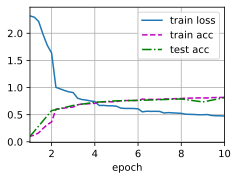

In [6]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## Resumo

* A CNN é uma rede que emprega camadas convolucionais.
* Em uma CNN, intercalamos convoluções, não linearidades e (frequentemente) operações de agrupamento.
* Em uma CNN, as camadas convolucionais são normalmente organizadas de forma que diminuam gradualmente a resolução espacial das representações, enquanto aumentam o número de canais.
* Em CNNs tradicionais, as representações codificadas pelos blocos convolucionais são processadas por uma ou mais camadas totalmente conectadas antes de emitir a saída.
* LeNet foi indiscutivelmente a primeira implantação bem-sucedida de tal rede.

## Exercícios

1. Substitua o *pooling* médio pelo *pooling* máximo. O que acontece?
1. Tente construir uma rede mais complexa baseada em LeNet para melhorar sua precisão.
     1. Ajuste o tamanho da janela de convolução.
     1. Ajuste o número de canais de saída.
     1. Ajuste a função de ativação (por exemplo, ReLU).
     1. Ajuste o número de camadas de convolução.
     1. Ajuste o número de camadas totalmente conectadas.
     1. Ajuste as taxas de aprendizagem e outros detalhes de treinamento (por exemplo, inicialização e número de épocas).
1. Experimente a rede aprimorada no conjunto de dados MNIST original.
1. Exibir as ativações da primeira e da segunda camada do LeNet para diferentes entradas (por exemplo, suéteres e casacos).


[Discussions](https://discuss.d2l.ai/t/74)


<!--stackedit_data:
eyJoaXN0b3J5IjpbMzgwMzk0NjcwLC0xOTUzODQ4Nzk4LC03Nz
cwODI1NDEsLTEyMjQxMzk5MTJdfQ==
-->
